# Project Overiew: Building Segmentation with FastAI using crowdAI Dataset

**Author** : [Anastasiia Zolotova](mailto:an.zolotova@outlook.com)

### Overview

This notebook is a part of my Bachelor's thesis project at Petro Mohyla Black Sea National University **"Software for Infrastructure Objects Detection Using Machine Learning"**. The following code provides a workflow for training a building segmentation U-Net model with a ResNet34 backbone using FastAI and the dataset for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge). The dataset is available at : [https://www.crowdai.org/challenges/mapping-challenge/dataset_files](https://www.crowdai.org/challenges/mapping-challenge/dataset_files).

##### Tools & Techniques

- **Model:** U-Net with ResNet34 encoder (transfer learning)
- **Framework:** fastai + PyTorch
- **Metrics:**
    - Jaccard Score (also known as Intersection over Union)
    - Accuracy (describes how the model performs across all classes)
    - Dice coefficient (measures pixel-level accuracy)
- **Pipeline:** Custom image-mask pairing via [`fastai`'s DataBlock API](https://docs.fast.ai/data.block.html)


To get started, create a new virtual environment.

Then download the dataset, and unzip it inside this folder, so that you have a directory structure like this :

```bash
|-- data/
|   |-- test/
|   |   |-- images (has all the images for testing)
|   |   |-- annotations
|   |   |   |__ annotation.json : Annotation of the data in MS COCO format
|   |   |   |__ annotation_non_augmented.json : Smaller version of the previous dataset
|   |-- train/
|   |   |-- images (has all the images for training)
|   |   |-- annotations
|   |   |   |__ annotation.json : Annotation of the data in MS COCO format
|   |   |   |__ annotation_non_augmented.json : Smaller version of the previous dataset
|   |-- val/
|   |   |-- images (has all the images for validating)
|   |   |-- annotations
|   |   |   |__ annotation.json : Annotation of the data in MS COCO format
|   |   |   |__ annotation_non_augmented.json : Smaller version of the previous dataset
```

If you have not already installed all the requirements for this notebook, you can still install them by :

In [ ]:
%pip install -r requirements.txt

## Step 1 – Set up the environment

**Note**: The computational environment for this project was an ARM architecture. PyTorch uses the new Metal Performance Shaders (MPS) backend for GPU training acceleration. Since it is in the beta phase, some operations are not yet supported on MPS device, which influenced the performance. You can find more details at [Apple Developer website](https://developer.apple.com/metal/pytorch/) and [PyTorch 2.5 documentation](https://docs.pytorch.org/docs/2.5/notes/mps.html).

### Define torch device

In [ ]:
import torch

print(torch.__version__)
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

# Change "mps" to "cuda" if you have a CUDA-supported GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
torch.mps.current_allocated_memory()

2.5.1
True
True
Using device: mps


0

### Import dependencies

**Important Note**: Install `pycocotools` from this fork : 
```
pip install git+https://github.com/crowdai/coco.git#subdirectory=PythonAPI
```

In [2]:
from fastai.vision.all import *
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

### Configuration Variables

In [ ]:
base_dir = Path("data/train")
images_dir = base_dir / "images"
annotations_path = base_dir / "annotations/annotation.json"
masks_dir = base_dir / "masks"

masks_dir.mkdir(parents=True, exist_ok=True)

## Step 2 – Convert COCO Polygons to Binary Masks (optional)

CrowdAI Mapping Challenge Dataset releases the annotations in the [MS COCO format](http://cocodataset.org/#format). Please read up more about it at : [http://cocodataset.org/#format](http://cocodataset.org/#format).

If you already have masks in your project, there is no need in running this code.

In [ ]:
coco = COCO(annotations_path)

image_ids = coco.getImgIds()

for img_id in tqdm(image_ids, desc="Generating masks"):
    img_meta = coco.loadImgs(img_id)[0]
    width, height = img_meta["width"], img_meta["height"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((height, width), dtype=np.uint8)
    for ann in anns:
        rle = maskUtils.frPyObjects(ann['segmentation'], height, width)
        m = maskUtils.decode(rle)
        if len(m.shape) == 3:
            m = np.any(m, axis=2)
        mask[m > 0] = 1

    mask_img = Image.fromarray(mask.astype(np.uint8))
    mask_img.save(masks_dir / img_meta["file_name"].replace(".jpg", ".png"))

loading annotations into memory...
Done (t=12.79s)
creating index...
index created!


## Step 3 – Set up FastAI DataBlock for Segmentation

First we need to write a function that links each image to its matching mask (e.g., "images/5.jpg" ↔ "masks/5.png"). This ensures that training data is properly aligned:

In [6]:
def label_func(fn):
    return fn.parent.parent / "masks" / f"{fn.stem}.png"

Next we initialize `codes` and `subset_images` to choose the amount of images for training.

codes=['background', 'building'] are for binary segmentation (0 = background, 1 = building).

In [7]:
all_images = get_image_files(images_dir)
# we will use just 10000 images from the dataset
subset_images = random.sample(all_images, 10000)
codes = ['background', 'building']

In [8]:
len(subset_images)

10000

And finally, we build a data pipeline that tells fastai how to load and transform the images/masks into batches that can be used for training:

In [9]:
block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=lambda _: subset_images,
    get_y=label_func,
    splitter=RandomSplitter(),
)

In this way, we will use 8000 of images for training and 2000 for validating.

## Step 4 – Create DataLoaders
Preparing the images/masks into batches.

In [17]:
dls = block.dataloaders(images_dir, bs=16, device=device)

## Step 4 – Train the Model

Here we create a U-Net model with a pretrained ResNet34 backbone using fastai‘s `unet_learner`.

In [12]:
learn = unet_learner(dls=dls,
                     arch=resnet34,
                     metrics=[Jaccard(axis=1, average='micro'), partial(accuracy, axis=1), F1Score(), Dice()]
                     )

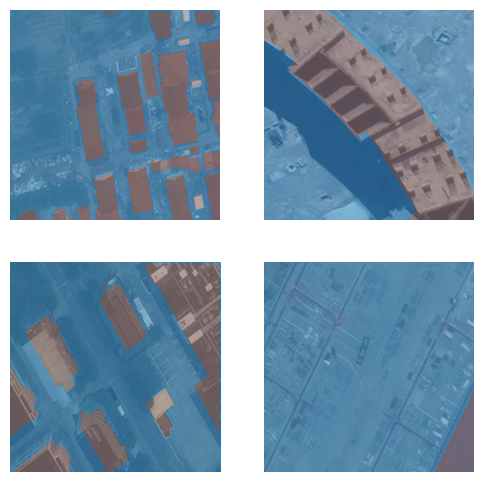

In [21]:
learn.dls.show_batch(max_n=4)

In [ ]:
learn.summary()

DynamicUnet (Input shape: 16 x 3 x 300 x 300)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 150 x 150 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 75 x 75   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

We train (fine-tune) the U-Net model for 1 epoch on our building footprint data.

In [20]:
learn.fit(1)

epoch,train_loss,valid_loss,dice,time
0,0.286558,0.254751,0.734590,19:12


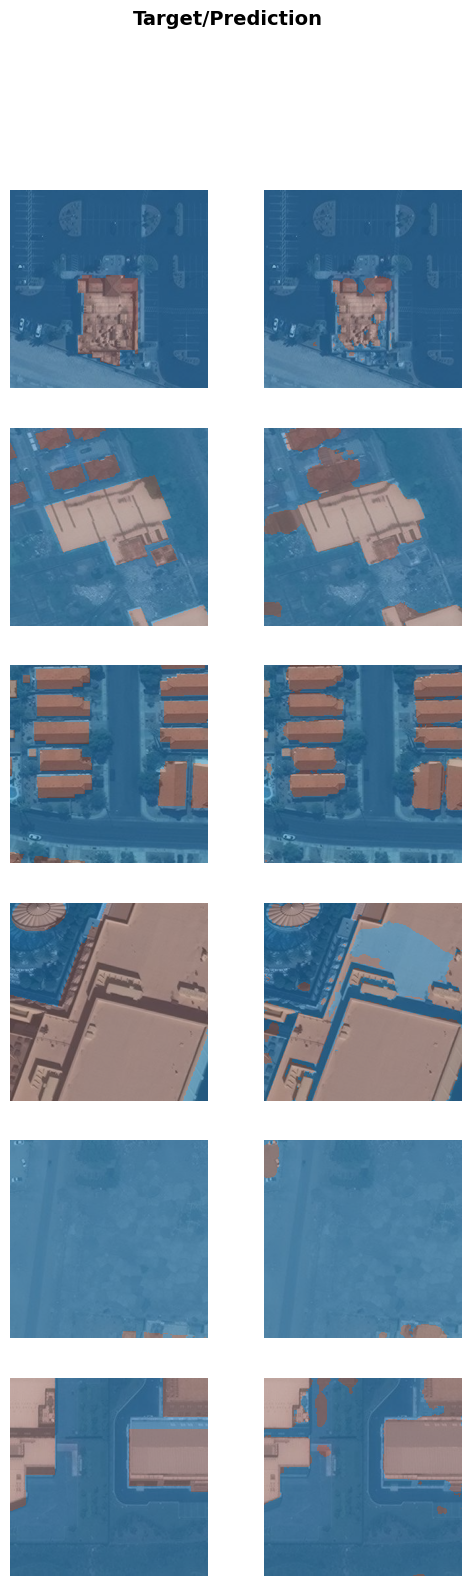

In [30]:
learn.show_results(max_n=6)

Tune learning rate using fastai's learning rate finder. This is done by choosing suggested learning rate from the longest valley's index:

/Users/anastasiia/Downloads/local-runtime/.localvenv/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file

SuggestedLRs(valley=2.0892961401841603e-05)

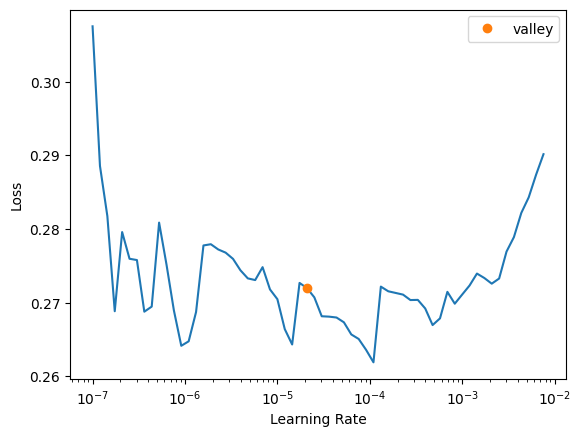

In [26]:
learn.lr_find()

Next we unfreeze our model and finish training it for 3 epochs using discriminative learning rates between 1e-5 and the recommended learning rate. Early in the training the LR increases and then decreases toward the end.

In [ ]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(3, slice(1e-5, 2e-5))

epoch,train_loss,valid_loss,dice,time
0,0.247704,0.229238,0.754649,20:13
1,0.216507,0.214181,0.772620,20:08
2,0.205216,0.210637,0.781177,20:25


### Step 5 – Evaluate the Model

To understand how well our model performs, we visualize a real example from the validation set. Here we compare:

- The **ground truth mask** (actual building locations)
- The **predicted mask** (model’s output)

This allows us to visually inspect how accurately the model is identifying building footprints.

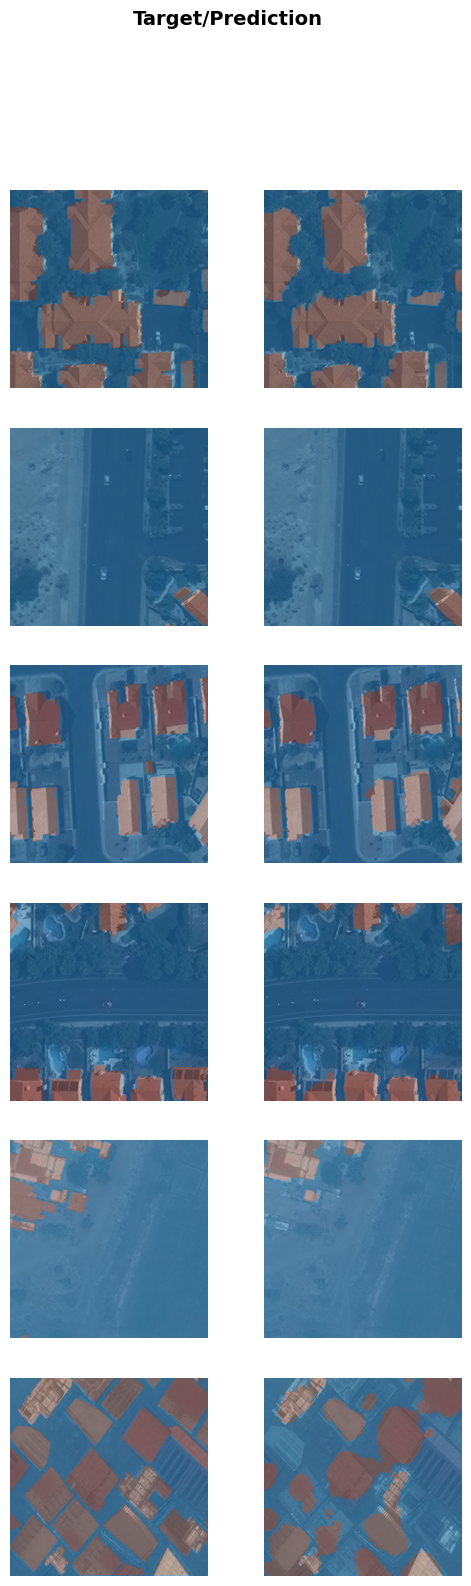

In [32]:
learn.show_results(max_n=6)

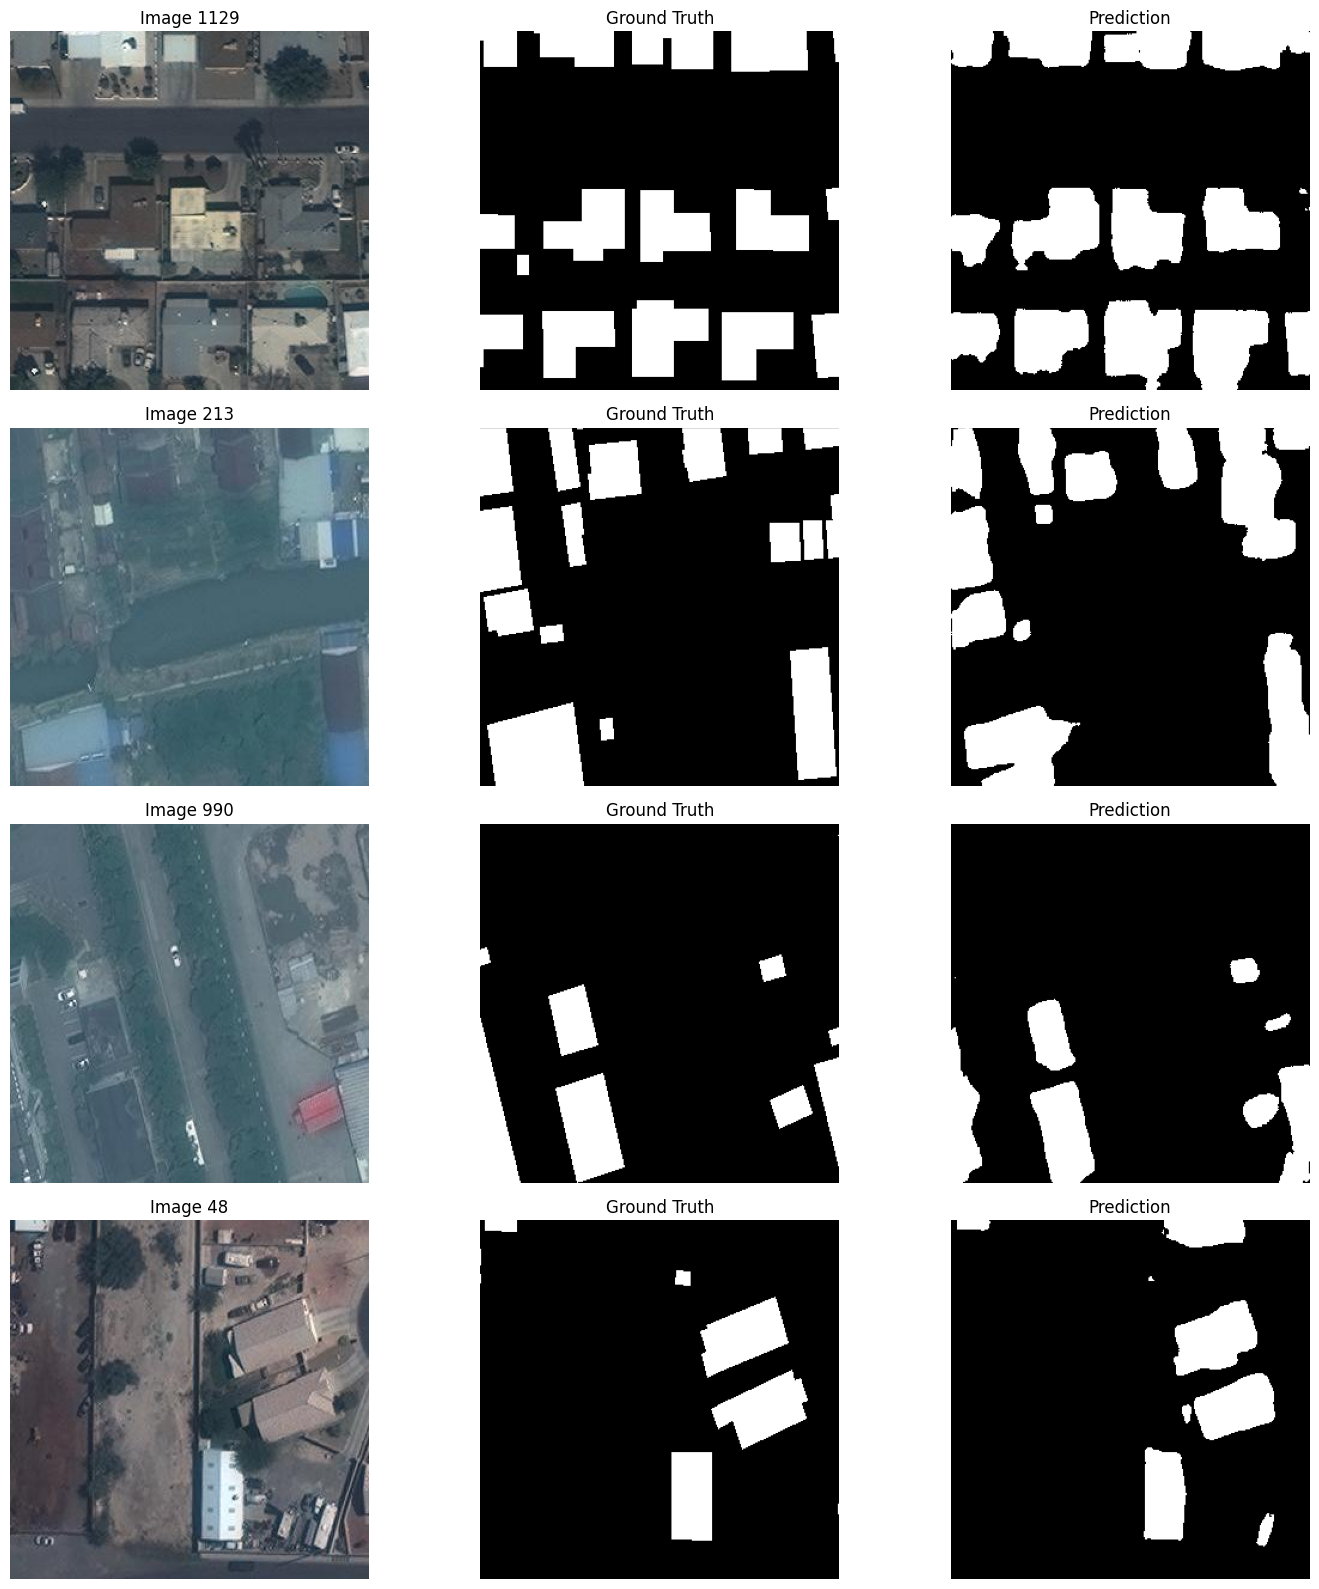

In [ ]:
num_samples = 4
val_size = len(dls.valid_ds)
random_indices = random.sample(range(val_size), num_samples)

plt.figure(figsize=(15, 4 * num_samples))

for i, idx in enumerate(random_indices):
    img, true_mask = dls.valid_ds[idx]

    pred_mask, _, _ = learn.predict(img)

    img_np = np.array(img)
    true_mask_np = np.array(true_mask)
    pred_mask_np = np.array(pred_mask)

    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(img_np)
    plt.title(f"Image {idx}")
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(true_mask_np, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(pred_mask_np, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Step 6 – Save the Model

Pass an export file name and [Learner.export](https://docs.fast.ai/learner.html#learner.export) will pickle and save the learner object to the Learner.path, which by default is the current working directory unless a path location was set in the DataBlock.dataloaders or Learner.

Export pickles the entire learner object. Including the dataloaders, loss function, optimizer, augmentations or transforms, and all callbacks.

In [ ]:
learn.export("building_segmentation.pkl")

[load_learner](https://docs.fast.ai/learner.html#load_learner) requires all our custom code be in the exact same place as when exporting our [Learner](https://docs.fast.ai/learner.html#learner).

Which means that later we will need `label_func` for loading our Learner with:

```bash
learn = load_learner("building-segmentation.pkl")
```